In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import statsmodels.api as sm
import seaborn as sns
import scipy
%matplotlib inline


from sklearn import linear_model
from pathlib import Path
from matplotlib import pyplot as plt

In [3]:
data = Path().absolute()/'data'

## Importando dados de citação

In [4]:
desapro_df = pd.read_csv(data/'citacoes_desapropriacao.csv')

In [5]:
desapro_df.shape

(108, 21)

Removing Sumulas

In [6]:
desapro_df.query('~ @desapro_df.caso.str.contains("sumula")',
                 engine='python', inplace=True)

In [7]:
print(desapro_df.sort_values('citacoes_total', ascending=False)[['caso','citacoes_total']].head(8))

         caso  citacoes_total
4    adi 2332              14
3    adi 2260               8
58  re 543974               8
37  re 172816               7
78   re 82300               5
64  re 635336               5
47  re 247866               5
65   re 64559               5


In [8]:
desapro_df.groupby('citacoes_total').size().to_frame()

,0
citacoes_total,
2,64
3,15
4,6
5,4
7,1
8,2
14,1


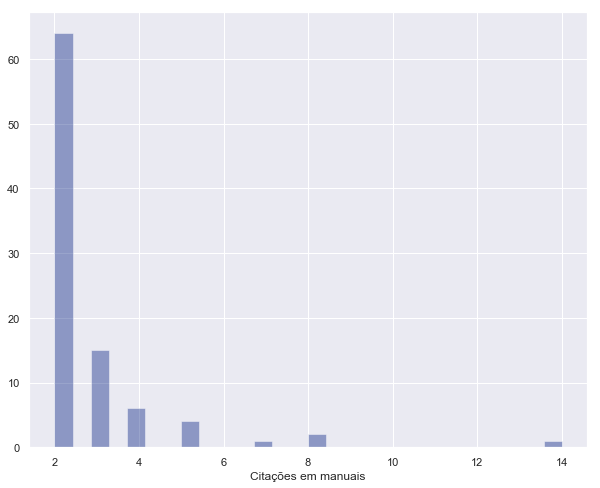

In [42]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette('dark')
sns.distplot(desapro_df.citacoes_total, kde=False, vertical=False, axlabel=u'Citações em manuais')
fig.savefig('graficos/histo_manuais_desapropriacao.png')

In [9]:
desapro_df.head()

,caso,"Alessandro Dantas Coutinho e Ronald Kruger Rodor, Manual de Direito Administrativo",Antonio Cecílio Moreira Pires Direito Administrativo 2a Ed,Aragão Curso de Direito Administrativo 2a Ed,Bandeira de Mello Curso de Direito Administrativo 31a Ed,Diógenes Gasparini Direito Administrativo 17a Ed,Fernanda Marinela Direito Administrativo 11a Ed,Hely Lopes Meirelles Direito Administrativo Brasileira 42a Ed,Irene Patrícia Nohara Direito Administrativo 8a Ed,José dos Santos Carvalho Filho 28a Ed,...,Marcio Pestana Direito Administrativo Brasileiro 4a Ed,Maria Sylvia Zanella di Pietro 31a Ed,Marçal Justen Filho Curso de Direito Administrativo 12a Ed,Moreira Neto Curso de Direito Administrativo 16a Ed,Odete Medauar Curso de Direito Administrativo 21a Ed,Odete Medauar Odete Medauar Curso de Direito Administrativo 11a Ed,Reinaldo Couto Curso de Direito Administrativo 2a Ed,Ricardo Alexandre e João de Deus Direito Administrativo 4a Ed,citado,citacoes_total
0,aco 2162,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,2
1,adi 1187,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
2,adi 2213,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,3
3,adi 2260,0,0,0,0,1,1,0,1,0,...,0,1,0,0,0,0,1,1,1,8
4,adi 2332,1,0,0,1,1,1,1,1,1,...,1,0,1,0,1,1,1,1,1,14


## Carregando Grafo

In [8]:
desapro_graph = nx.read_graphml(str(data.parent/'grafo_desapropriacao.graphml'))

### Gerando gráfico com a distribuição dos graus

Gráfico de In Degree

In [9]:
in_degree = pd.Series(dict(desapro_graph.in_degree), name='Número de Citações Recebidas').reset_index()

TypeError: cannot concatenate 'str' and 'int' objects

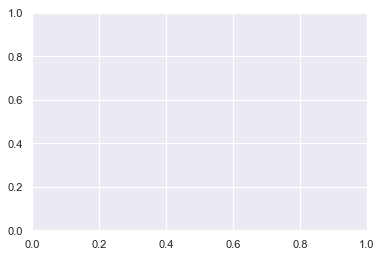

In [10]:
sns.set()

sns.distplot(in_degree)

In [10]:
in_d_dist = in_degree.groupby('Número de Citações Recebidas').index.nunique().reset_index()

in_d_dist.rename(columns={'index': 'Número de Casos'}, inplace=True)

In [11]:
in_d_dist.head()

,Número de Citações Recebidas,Número de Casos
0,0,3973
1,1,218
2,2,113
3,3,57
4,4,48


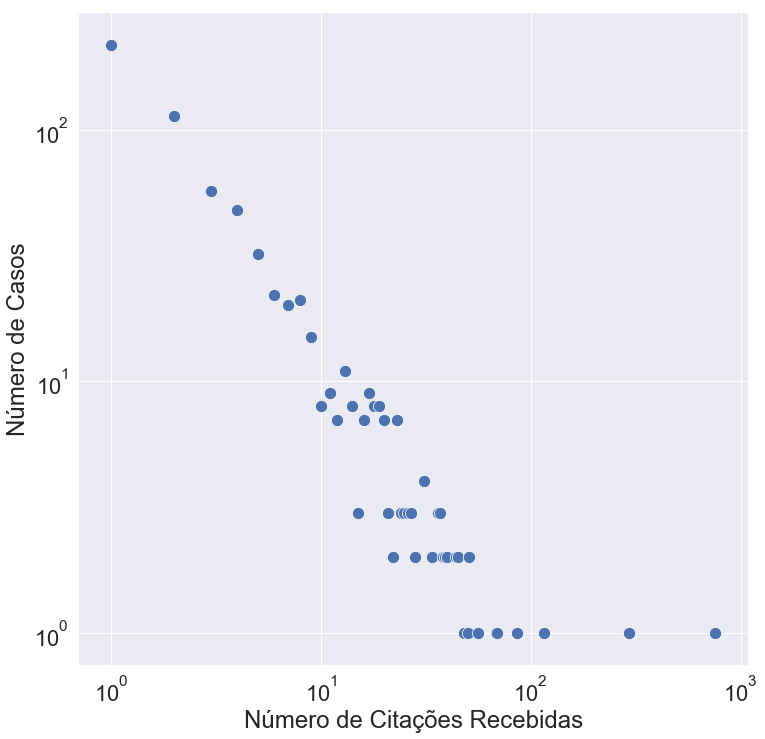

In [12]:
sns.set(rc={'figure.figsize':(12,12)}, font_scale=2)

fig, ax = plt.subplots(figsize=(12,12))

plt.xscale('log')
plt.yscale('log')

in_degree_graph = sns.scatterplot(x='Número de Citações Recebidas', y='Número de Casos', data=in_d_dist.drop(0), s=150,)

In [13]:
fig.savefig('graficos/in_desapropriacao.png')

Gráfico de Out Degree

In [14]:
out_degree = pd.Series(dict(desapro_graph.out_degree), name='Número de Citações Realizadas').reset_index()

In [15]:
out_d_dist = out_degree.groupby('Número de Citações Realizadas').index.nunique().reset_index()

out_d_dist.rename(columns={'index': 'Número de Casos'}, inplace=True)

In [16]:
out_d_dist.head()

,Número de Citações Realizadas,Número de Casos
0,0,2213
1,1,1328
2,2,417
3,3,185
4,4,214


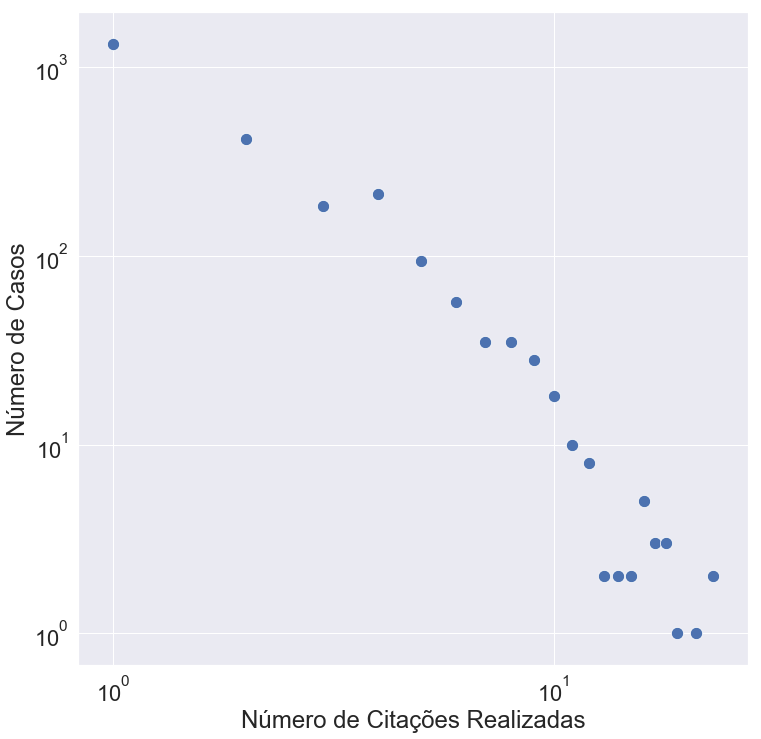

In [17]:
sns.set(rc={'figure.figsize':(12,12)}, font_scale=2)

fig, ax = plt.subplots(figsize=(12,12))

plt.xscale('log')
plt.yscale('log')

in_degree_graph = sns.scatterplot(x='Número de Citações Realizadas', y='Número de Casos', data=out_d_dist.drop(0), s=150,)

In [18]:
fig.savefig('graficos/out_desapropriacao.png')

### Removendo nós roxo - comunidade relativa ao RE 453740 que trata de juros para remuneração de servidores públicos

In [19]:
other_nodes = [n for n,v in desapro_graph.nodes(data=True) if v['Modularity Class'] != 1774]

In [20]:
len(other_nodes)

3903

In [21]:
graph = desapro_graph.subgraph(other_nodes)

### Calculando PageRank e HITS

In [22]:
pr_d = pd.Series(nx.algorithms.link_analysis.pagerank(graph),
                 name='page_rank').to_frame()

In [23]:
hub, auth = nx.algorithms.link_analysis.hits(graph)

In [24]:
hub_d = pd.Series(hub, name='hub_score').to_frame()

auth_d = pd.Series(auth, name='auth_score').to_frame()

Adicionando Modularidade

In [25]:
mod_d = pd.Series(nx.get_node_attributes(graph, 'Modularity Class'),
                  name='modularity').to_frame()

Obtendo número de citações

In [26]:
n_cit = pd.Series(nx.get_node_attributes(graph, 'In-Degree'),
                  name='n_citacoes').to_frame()

Gerando Dataframe com todas as informações

In [27]:
desaprop_info = mod_d.join(n_cit).join(pr_d).join(auth_d).join(hub_d)

In [28]:
desaprop_info.index = desaprop_info.index.str.lower()

Incluindo MARC In-degree

In [29]:
desaprop_info['marc'] = 1 + np.log2(desaprop_info['n_citacoes'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


In [30]:
desaprop_info.head()

,modularity,n_citacoes,page_rank,auth_score,hub_score,marc
re 487446,162,0,0.000155,0.000000e+00,1.332038e-78,-inf
re 665719,750,0,0.000155,0.000000e+00,4.101548e-07,-inf
ms 24190,764,2,0.000185,7.666748e-10,1.410308e-10,2.000000
are 641021,184,1,0.000198,3.846871e-08,1.141110e-07,1.000000
ai 847566,750,14,0.001586,1.022753e-04,1.194375e-05,4.807355


substituindo infinitos por 0

In [31]:
desaprop_info.replace(-np.inf, 0, inplace=True)

#### Gerando Percentil para cada coluna

**OBs: Problema é que 82,4% dos dados estão empatados com page_rank mínimo.**

In [32]:
for c in desaprop_info[['page_rank', 'auth_score', 'hub_score']].columns:
    desaprop_info[c + '_quantile'] = scipy.stats.rankdata(desaprop_info[c], method='max')*100/desaprop_info.shape[0]

### Juntando informação de citação com as medidas de rede

In [33]:
desaprop_info.index.name = 'caso'
desaprop_info.reset_index(drop=False, inplace=True)

desaprop_info.shape

(3903, 10)

In [34]:
desapro_df = desapro_df.merge(desaprop_info, how='right')

desapro_df[['citado', 'page_rank']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3903 entries, 0 to 3902
Data columns (total 2 columns):
citado       22 non-null float64
page_rank    3903 non-null float64
dtypes: float64(2)
memory usage: 91.5 KB


In [35]:
desapro_df.fillna(0, inplace=True)
desapro_df.head()

,caso,"Alessandro Dantas Coutinho e Ronald Kruger Rodor, Manual de Direito Administrativo",Antonio Cecílio Moreira Pires Direito Administrativo 2a Ed,Aragão Curso de Direito Administrativo 2a Ed,Bandeira de Mello Curso de Direito Administrativo 31a Ed,Diógenes Gasparini Direito Administrativo 17a Ed,Fernanda Marinela Direito Administrativo 11a Ed,Hely Lopes Meirelles Direito Administrativo Brasileira 42a Ed,Irene Patrícia Nohara Direito Administrativo 8a Ed,José dos Santos Carvalho Filho 28a Ed,...,citacoes_total,modularity,n_citacoes,page_rank,auth_score,hub_score,marc,page_rank_quantile,auth_score_quantile,hub_score_quantile
0,aco 2162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,564,3,0.000536,7.566777e-104,0.000000e+00,2.584963,94.183961,84.704074,56.699974
1,adi 2213,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.0,764,13,0.001404,2.659220e-08,1.716093e-11,4.700440,98.129644,90.878811,62.567256
2,adi 2260,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,8.0,184,3,0.000326,5.747924e-06,0.000000e+00,2.584963,91.006918,94.952601,56.699974
3,adi 2332,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,14.0,663,116,0.012114,5.316776e-04,0.000000e+00,7.857981,99.974379,98.565206,56.699974
4,adi 4357,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,4.0,751,6,0.000838,1.594614e-04,0.000000e+00,3.584963,96.438637,98.078401,56.699974


## Gerando matriz de correlação 

In [36]:
des_cor = desapro_df[
    [
        'page_rank_quantile',
        'auth_score_quantile',
        'hub_score_quantile',
        'citado']].corr(method='pearson')

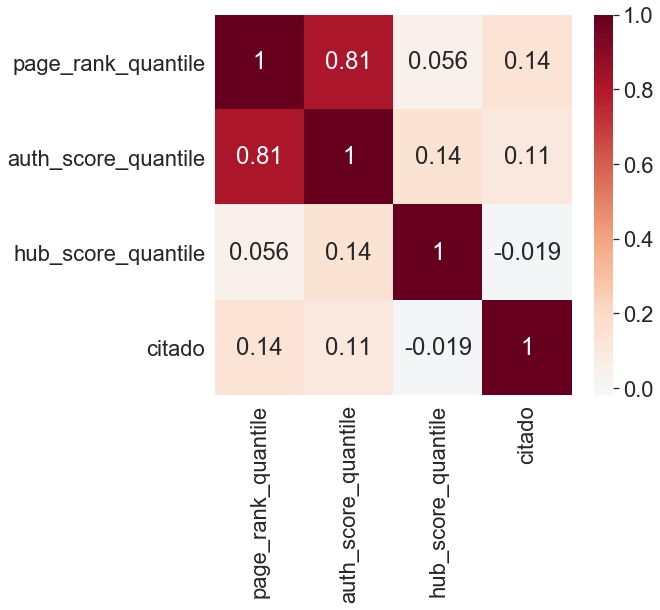

In [37]:
fig, ax = plt.subplots(figsize=(8,7))

h = sns.heatmap(des_cor, cmap='RdBu_r', center=0, annot=True)

fig.savefig('graficos/correlation_table', bbox_inches='tight')

## Testando Modelos

Linear Model

In [38]:
y_d1 = desapro_df.page_rank_quantile
y_d2 = desapro_df.auth_score_quantile

x_d = desapro_df.citacoes_total

x_d = sm.add_constant(x_d, False)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [39]:
linmodel_d_pr = sm.OLS(y_d1, x_d, missing='drop').fit()
linmodel_d_pr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     page_rank_quantile   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     61.36
Date:                Tue, 23 Apr 2019   Prob (F-statistic):           6.08e-15
Time:                        11:07:39   Log-Likelihood:                -10907.
No. Observations:                3903   AIC:                         2.182e+04
Df Residuals:                    3901   BIC:                         2.183e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
citacoes_total     1.4838      0.189      7.833      0.000       1.112       1.855
const             83.9360      0.063   1322.745      0.000      83.812      84.060
==============================================================================
Omnibus:                     1995.021   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9355.935
Skew:                           2.581   Prob(JB):                         0.00
Kurtosis:                       8.557   Cond. No.                         2.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
linmodel_d_pr = sm.OLS(y_d2, x_d, missing='drop').fit()
linmodel_d_pr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     auth_score_quantile   R-squared:                       0.010
Model:                             OLS   Adj. R-squared:                  0.010
Method:                  Least Squares   F-statistic:                     41.33
Date:                 Tue, 23 Apr 2019   Prob (F-statistic):           1.44e-10
Time:                         11:07:39   Log-Likelihood:                -10905.
No. Observations:                 3903   AIC:                         2.181e+04
Df Residuals:                     3901   BIC:                         2.183e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
citacoes_total     1.2172      0.189      6.429      0.000       0.846       1.588
const             83.9345      0.063   1323.357      0.000      83.810      84.059
==============================================================================
Omnibus:                     2009.203   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9555.719
Skew:                           2.596   Prob(JB):                         0.00
Kurtosis:                       8.639   Cond. No.                         2.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

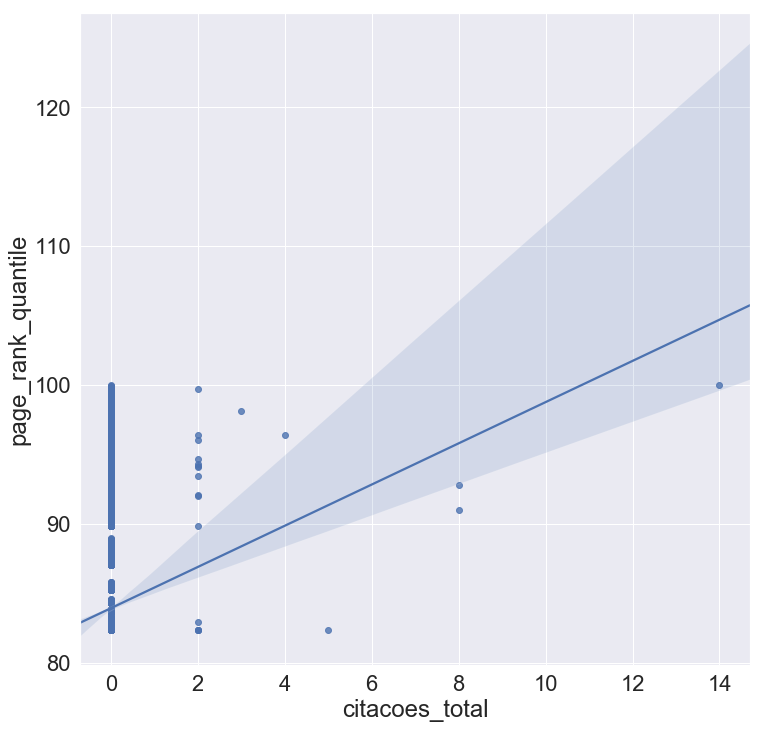

In [41]:
sns.regplot(x='citacoes_total', y='page_rank_quantile', data=desapro_df)

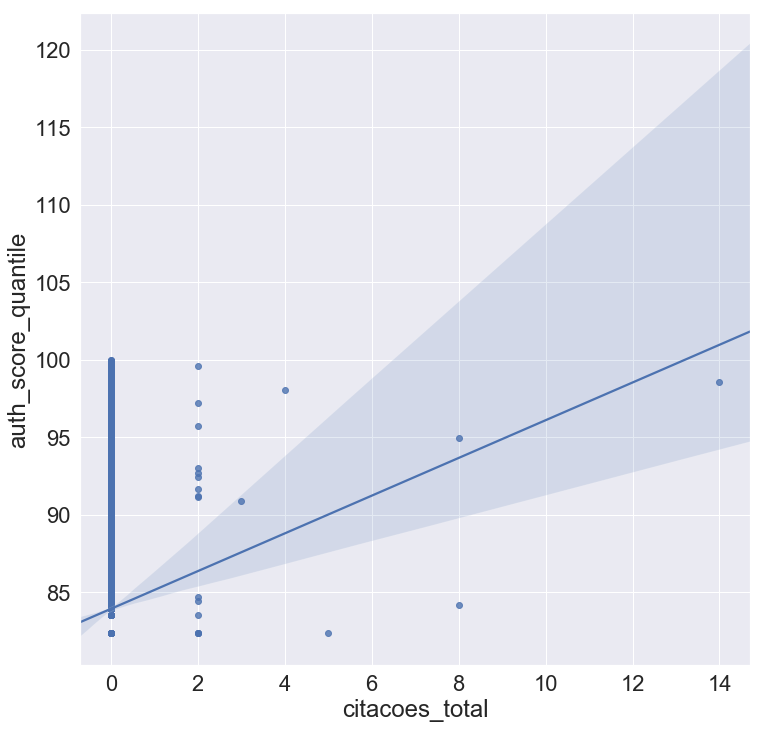

In [42]:
sns.regplot(x='citacoes_total', y='auth_score_quantile', data=desapro_df)

### Modelo Logístico

testando modelo com todas as varíavais

In [43]:
X = desapro_df[['page_rank_quantile', 'auth_score_quantile', 'hub_score_quantile', 'n_citacoes']]
X = sm.add_constant(X)

logit_model = sm.Logit(exog=X,
                       endog=desapro_df['citado'])

logit_result = logit_model.fit(disp=False)

In [44]:
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 citado   No. Observations:                 3903
Model:                          Logit   Df Residuals:                     3898
Method:                           MLE   Df Model:                            4
Date:                Tue, 23 Apr 2019   Pseudo R-squ.:                  0.1636
Time:                        11:07:41   Log-Likelihood:                -113.64
converged:                       True   LL-Null:                       -135.86
                                        LLR p-value:                 5.164e-09
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -22.2878      3.437     -6.486      0.000     -29.023     -15.552
page_rank_quantile      0.1766      0.053      3.358      0.001       0.074       0.280
auth_score_quantile     0.0517      0.058      0.896      0.370      -0.061       0.165
hub_score_quantile     -0.0427      0.022     -1.972      0.049      -0.085      -0.000
n_citacoes              0.0024      0.008      0.297      0.766      -0.013       0.018
=======================================================================================
"""

Testando modelo sem número de citações

In [45]:
X = desapro_df[['page_rank_quantile', 'auth_score_quantile', 'hub_score_quantile']]
X = sm.add_constant(X)

logit_model = sm.Logit(exog=X,
                       endog=desapro_df['citado'])

logit_result = logit_model.fit(disp=False)

logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 citado   No. Observations:                 3903
Model:                          Logit   Df Residuals:                     3899
Method:                           MLE   Df Model:                            3
Date:                Tue, 23 Apr 2019   Pseudo R-squ.:                  0.1633
Time:                        11:07:41   Log-Likelihood:                -113.68
converged:                       True   LL-Null:                       -135.86
                                        LLR p-value:                 1.257e-09
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -22.6835      3.154     -7.191      0.000     -28.866     -16.501
page_rank_quantile      0.1787      0.052      3.446      0.001       0.077       0.280
auth_score_quantile     0.0546      0.056      0.969      0.333      -0.056       0.165
hub_score_quantile     -0.0430      0.022     -1.988      0.047      -0.085      -0.001
=======================================================================================
"""

Apenas Authority e Hub

In [46]:
X = desapro_df[['auth_score_quantile',
                'hub_score_quantile']]
X = sm.add_constant(X)

logit_model = sm.Logit(exog=X,
                       endog=desapro_df['citado'])

logit_result4 = logit_model.fit(disp=False)

logit_result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 citado   No. Observations:                 3903
Model:                          Logit   Df Residuals:                     3900
Method:                           MLE   Df Model:                            2
Date:                Tue, 23 Apr 2019   Pseudo R-squ.:                  0.1240
Time:                        11:07:41   Log-Likelihood:                -119.02
converged:                       True   LL-Null:                       -135.86
                                        LLR p-value:                 4.855e-08
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -19.7177      2.876     -6.856      0.000     -25.354     -14.081
auth_score_quantile     0.2045      0.033      6.262      0.000       0.140       0.269
hub_score_quantile     -0.0486      0.021     -2.354      0.019      -0.089      -0.008
=======================================================================================
"""

In [47]:
# print(logit_result4.summary().as_latex())

Regressão PageRank e Hub

In [48]:
X = desapro_df[['page_rank_quantile',
                'hub_score_quantile']]
X = sm.add_constant(X)

logit_model = sm.Logit(exog=X,
                       endog=desapro_df['citado'])

logit_result5 = logit_model.fit(disp=False)

logit_result5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 citado   No. Observations:                 3903
Model:                          Logit   Df Residuals:                     3900
Method:                           MLE   Df Model:                            2
Date:                Tue, 23 Apr 2019   Pseudo R-squ.:                  0.1598
Time:                        11:07:41   Log-Likelihood:                -114.15
converged:                       True   LL-Null:                       -135.86
                                        LLR p-value:                 3.706e-10
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -21.6902      3.021     -7.179      0.000     -27.612     -15.769
page_rank_quantile     0.2169      0.032      6.822      0.000       0.155       0.279
hub_score_quantile    -0.0366      0.021     -1.760      0.078      -0.077       0.004
======================================================================================
"""

In [49]:
# print(logit_result5.summary().as_latex())

Comando para exportar tabela em latex

In [50]:
# print(logit_result.summary().as_latex())

## Testando Modelo Por Bootstrap

In [51]:
def get_logllh(prob_array, exp_array):
    arr = []
    for i, n in enumerate(exp_array):
        if n == 1:
            arr.append(prob_array[i])
        else:
            arr.append(1 - prob_array[i])
    log_arr = np.log(arr)
    return np.sum(log_arr)


def bootstrap_model(predicted_values):
    # Realizando experimento
    rand_vector = np.random.rand(predicted_values.shape[0])
    exp_realization = (predicted_values > rand_vector) * 1
    n_previstos = np.sum(exp_realization)
    print(n_previstos)
    return get_logllh(predicted_values, exp_realization)


def bootstrap_null(prob, exp_len, prob_array):
    # Realizando experimento
    rand_vector = np.random.rand(exp_len)
    exp_realization = (rand_vector < prob) * 1
    return get_logllh(prob_array, exp_realization)


def test_bootstrap_model(fitted_model, X, n_observations, n_iter=500, n_jobs=2):
    from joblib import Parallel, delayed
    predicted_values = fitted_model.predict(X)
    exp_len = predicted_values.shape[0]
    p = n_observations/exp_len
    # Utilizando joblib para paralelizar loop
    model_llh = Parallel(n_jobs=n_jobs)(delayed(bootstrap_model)(predicted_values) for i in range(n_iter))
    null_llh = Parallel(n_jobs=n_jobs)(delayed(bootstrap_null)(prob=p,exp_len=exp_len, prob_array=predicted_values) for i in range(n_iter))
    
    print('Informações sobre LogLLH do Modelo:')
    print('Media:', np.mean(model_llh))
    print('Std', np.std(model_llh))
    print('Max:', np.max(model_llh))
    print('Min:', np.min(model_llh))
    
    print('Informações sobre LogLLH Nulo:')
    print('Media:', np.mean(null_llh))
    print('Std', np.std(null_llh))
    print('Max:', np.max(null_llh))
    print('Min:', np.min(null_llh))
    
    return model_llh, null_llh

In [52]:
n_obs = desapro_df.citado.sum()

model_arr, null_arr = test_bootstrap_model(logit_result5, X, n_obs, n_iter=50000)

Informações sobre LogLLH do Modelo:
Media: -114.13698880939117
Std 20.673035227881922
Max: -47.053377439663336
Min: -223.4848976138567
Informações sobre LogLLH Nulo:
Media: -152.30913667689398
Std 27.93208078355023
Max: -56.01094250273071
Min: -297.83099023869374


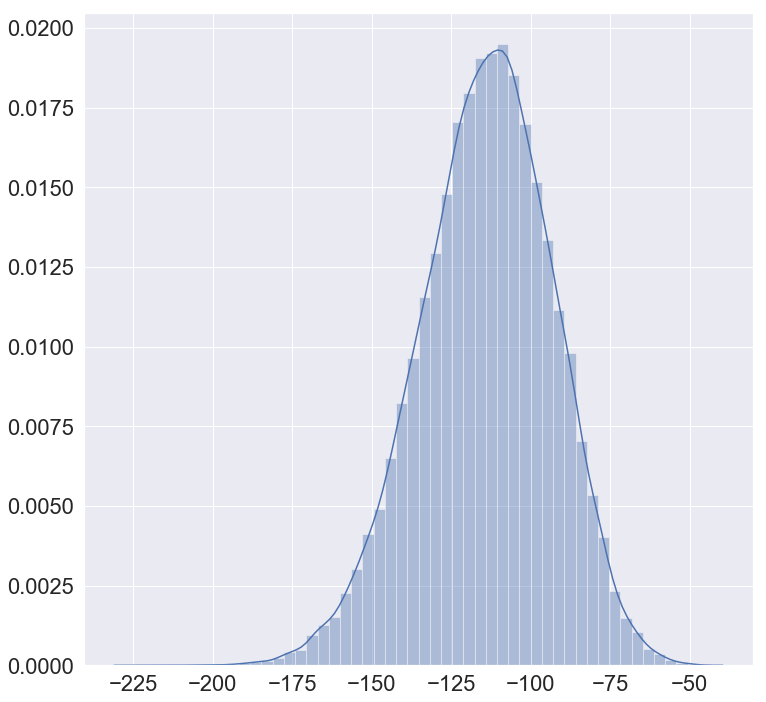

In [53]:
sns.distplot(model_arr)

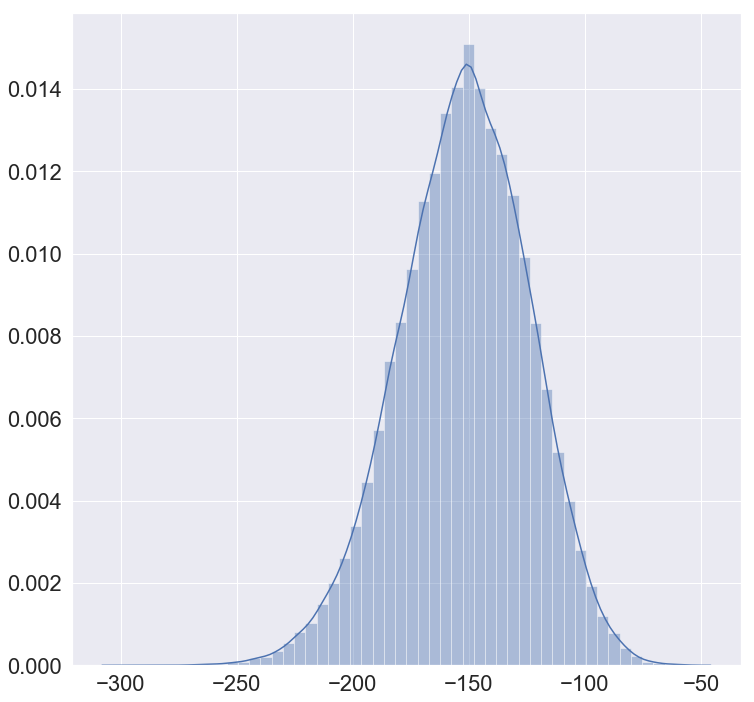

In [54]:
sns.distplot(null_arr)

## Testes

Correlação entre todas as variáveis calculadas

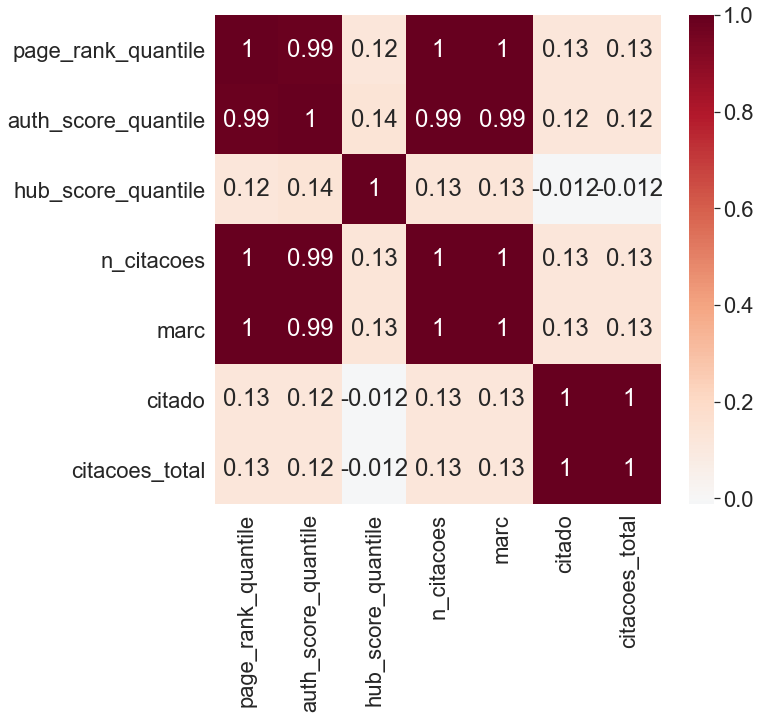

In [55]:
cor_geral = desapro_df[
    [
        'page_rank_quantile', 'auth_score_quantile',
        'hub_score_quantile', 'n_citacoes', 'marc',
        'citado', 'citacoes_total'
    ]
].corr(method='spearman')

fig, ax = plt.subplots(figsize=(10,9))

sns.heatmap(cor_geral, cmap='RdBu_r', center=0, annot=True)

Regressão com hub e MARC

In [56]:
X = desapro_df[['hub_score_quantile', 'marc']]
X = sm.add_constant(X)

logit_model = sm.Logit(exog=X,
                       endog=desapro_df['citado'])

logit_result3 = logit_model.fit(disp=False)

logit_result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 citado   No. Observations:                 3903
Model:                          Logit   Df Residuals:                     3900
Method:                           MLE   Df Model:                            2
Date:                Tue, 23 Apr 2019   Pseudo R-squ.:                  0.1594
Time:                        11:47:36   Log-Likelihood:                -114.20
converged:                       True   LL-Null:                       -135.86
                                        LLR p-value:                 3.918e-10
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.1858      1.356     -2.349      0.019      -5.843      -0.528
hub_score_quantile    -0.0449      0.022     -2.051      0.040      -0.088      -0.002
marc                   0.6293      0.087      7.204      0.000       0.458       0.801
======================================================================================
"""

In [57]:
# sns.regplot(x='page_rank_quantile', y='citado', data=desapro_df, fit_reg=True, logistic=True)

## Observações para alterar:

* Alta correlação (colinearidade?) entre page rank e authority. 
    * Não comprometeu modelo mas significância foi afetada
    * PR um pouco mais explicativo que authority